<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/live-tv-events/part_3_feature_engineering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Live TV Events Data Science Guides

# Part 3: Feature Engineering

<b>A How To Guide to aggregating data and creating features for forecasting from PredictHQ's Live TV Events.</b>

Designing features for forecasting will be affected by what you are forecasting and what you are trying to optimize.

The findings of Part 2 can be used to influence decisions dependant on your business domain. 

This notebook addresses some of the key considerations.

- <b>Time Granularity</b>
    - Daily 
    - Hourly (broadcast start time)
    - Hourly (broadcast duration)
    - Time of day
    
- <b>Viewership Measurement</b>
    - Total viewership
    - Max broadcast viewership
    - Broadcast count 

- <b>Sports and Leagues</b>
   - Only certain leagues


Viewership in this notebook has not been transformed and used as is. However, some transformations to viewership may be useful and could improve the relationship with your demand and the performance of your forecasting models. For example, a log10 transformation may be worth exploring to help reduce the skewness of the data.

The rest of this notebook goes through three different fictional use case ideas for how you could aggregate the data dependant on what is important to your company. It should provide a framework to create your own features or aggregation. 

### [Case 1](#case_1): 
- Interested in demand 24 hours a day
- Forecasting at the hourly level
- Interested in max viewership per league per hour
        
### [Case 2](#case_2): 
- Forecasting at the hourly level
- Event duration not impacting demand so aggregate to start time
- Target College sports fans

### [Case 3](#case_3):  
- Targeting evening demand
- Forecasting at the day level
- Targeting when people get together(very large viewership games only)
    

#### [Compare Features](#compare) 

### [Exploring TV Viewership with the Features API](#tv_views_features_api)
### [Case 4](#case_4)
- Forecasting at the day level
- Aggregating a sport (basketball)
- Comparing locations


<a id='setup'></a>
## Setup

If running on Google Colab uncomment the following blocks. Run `!pip install ipython ipykernel --upgrade` first then reset the kernal and run the rest of the notebook.

In [1]:
# !pip install ipython ipykernel --upgrade

In [2]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/live-tv-events
# !pip install predicthq>=1.8.3 aiohttp==3.7.4.post0 asyncio==3.4.3 backoff==1.10.0 bleach==3.3.0 calmap==0.0.9 iso8601==0.1.14 matplotlib==3.4.2 numpy==1.20.3 pandas==1.2.4 seaborn==0.11.1 uvloop==0.15.2

If running locally, configure the required dependencies in your Python environment by using the [requirements.txt](https://github.com/predicthq/phq-data-science-docs/blob/master/live-tv-events/requirements.txt) file which is shared alongside the notebook.

These requirements can be installed by runing the command `pip install -r requirements.txt`

In [3]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np

from predicthq import Client
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
import pytz

import sqlite3

<a id='csv_sdk'></a>
## SDK or CSV Data Access
This notebook can be run using both the CSV example data provided or if you have access to the PredictHQ Broadcast Endpoint you can use the code provided to call the SDK end point for the locations of interest to you. 

As using the SDK is not the focus of Part 3, a function is created to call the SDK. For guidance on how to use the SDK refer to Part 1. 

In [4]:
# Set whether to run with SDK or using provided CSV files
# Set to either 'CSV' or 'SDK'

# If using RUN_SETTING = 'CSV' update CURRENT_PLACENAME and CURRENT_PLACEID
# If using RUN_SETTING = 'SDK' update ACCESS_TOKEN, CURRENT_PLACENAME, CURRENT_PLACEID, START and END

RUN_SETTING = 'CSV'

START_DATE = '2019-01-01'
END_DATE = '2019-11-01'

CURRENT_PLACENAME = 'Los Angeles County'
CURRENT_PLACEID = 5368381

# Replace Access Token with own access token.
ACCESS_TOKEN = 'REPLACE_WITH_ACCESS_TOKEN'

In [5]:
def _extract_matching_label(event_labels, labels_to_match):
    '''For each broadcast the league and sport type need to be
    extracted. These labels are extracted from the labels.
    As the order of the labels varies this look up is
    required to compare to the frozenset of options.
    '''
    for label in labels_to_match:
        if label in event_labels:
            return label
    return None


SPORTS = frozenset([
        'american-football',
        'baseball',
        'basketball',
        'ice-hockey',
        'soccer',
    ])
LEAGUES = frozenset([
        'mlb',
        'mls',
        'nba',
        'ncaa',
        'nfl',
        'nhl',
    ])

def convert_timezone(row):
    """Convert event end time to broadcast location timezone from the event timezone.
    This will use either predicted or actual end time"""
    
    if row.get('dates_event', {}).get('predicted_end_local'):
            event_end_naive = row['dates_event']['predicted_end_local']
    elif row.get('dates_event', {}).get('end_local'):
            event_end_naive = row['dates_event']['end_local']
    event_timezone = pytz.timezone(row['dates_event']['timezone'])

    event_end_localtime= event_timezone.localize(event_end_naive, is_dst=None)
    event_end_utc = event_end_localtime.astimezone(pytz.utc)

    broadcast_timezone = row['dates_broadcast']['timezone']
    broadcast_end_localtime = event_end_utc.astimezone(pytz.timezone(broadcast_timezone))
    row['predicted_end_time_broadcast_local'] = broadcast_end_localtime.replace(tzinfo=None)

    return row

def query_location(place_id, start, end):
    '''Query SDK for broadcast data for one county between
    start and end.
    '''

    search_results = phq.broadcasts.search(phq_viewership__gte=100,
                                           start={'gte': START_DATE,
                                                  'lte': END_DATE},
                                           location__place_id=place_id,
                                           limit=500,
                                           broadcast_status='scheduled',
                                           ).iter_all()

    search_results = [result.to_dict() for result in search_results]

    df = pd.DataFrame(search_results)

    # Extract out additional information
    # 'event' stores the additional data about the physical event
    df = df.merge(df['event'].apply(pd.Series),
                  left_index=True,
                  right_index=True,
                  suffixes=('_broadcast', '_event'))

    # Extract sport and league from the labels in the nested event data.
    df['sport'] = df.labels.apply(_extract_matching_label, args=(SPORTS,))
    df['league'] = df.labels.apply(_extract_matching_label, args=(LEAGUES,))

    df['local_start_date'] = (df.dates_broadcast
                                .apply(
                                        lambda start_dt:
                                        (start_dt['start_local']).date()
                                       )
                              )

    df['county_place_id'] = (df.location_broadcast
                               .apply(
                                       lambda location:
                                       location['places'][0]['place_id']
                                     )
                             )

    df['local_start_datetime'] = (df.dates_broadcast
                                    .apply(
                                            lambda start_dt:
                                            (start_dt['start_local'])
                                          )
                                  )

    # Check for any events without a predicted or actual end time.
    # All broadcasts are expected to have a predicted end time or an actual end time.
    broadcast_id_no_endtime = [row['broadcast_id'] for _, row in df.iterrows() \
                               if not (row.get('dates_event', {}).get('predicted_end_local') or row.get('dates_event',{}).get('end_local'))]
    # Remove any broadcasts without a predicted end time.
    df = df[~df['broadcast_id'].isin(broadcast_id_no_endtime)]

    # Convert the predicted end time of the event to broadcast timezone.
    df = df.apply(convert_timezone, axis=1)

    df['sport_league'] = df['sport'] + '_' + df['league']
    # Calculate the duration of the broadcast. 
    df['duration'] = df['predicted_end_time_broadcast_local'] - df['local_start_datetime']
    df['duration_hours'] = df['duration'].dt.seconds/(60*60)
    df['total_viewing'] = df['duration_hours'] * df['phq_viewership']
    
    # Make sure we don't have any broadcasts with zero duration
    df = df[df['duration_hours']>0]

    return df

## Viewership Aggregations

<a id='case_1'></a>
### Case 1: 
- Interested in demand 24 hours a day
- Forecasting at the hourly level
- Interested in total viewers across all leagues

#### Hourly Aggregation

When aggregating at the hourly level the use of max viewership or total viewership should be considered.

When aggregating at the hourly level, there are two time granularity options. 
 - aggregate at the start time of broadcast.
 - aggregate across the whole time period of the game. 
    
Depending on your domain, you may be interested in viewership across the whole duration (including for example half time). Alternatively you may chose to use the broadcast start time but address this point within your forecasting techniques. 

For case 1, we'll use the max of viewerships across all broadcasts.

PHQ viewership prediction models use features that account for the number of other games in other leagues happening at the same time. Despite this, summing viewership should not be interpreted as unique individuals. If a person watches two NFL games in one day, they will be counted twice if ```sum``` is used in the aggregation, but only once if ```max``` is used. Deciding on whether to use the max or sum may depend on your domain.


In [6]:
if RUN_SETTING == 'SDK':
    phq = Client(access_token=ACCESS_TOKEN)
    df = query_location(place_id=CURRENT_PLACEID, start=START_DATE, end=END_DATE)
elif RUN_SETTING == 'CSV':
    df = pd.read_csv('data/tv_events_data/{}_county_raw.csv'.format(CURRENT_PLACEID))
    START_DATE =  '2019-02-02'
    END_DATE = '2021-01-31'
    df['local_start_datetime'] = pd.to_datetime(df['local_start_datetime'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [7]:
# To create data at the hourly level
# First create a list of hours between the start_date and end_date
start = datetime.strptime(START_DATE + ' 00:00:00', "%Y-%m-%d %H:%M:%S")
# 23:00 is the last hour of the range as this will include events between 23:00-23:59
end = datetime.strptime(END_DATE + ' 23:00:00', "%Y-%m-%d %H:%M:%S")
diff = end - start

# Calculate the total number of hours between start_date and end_date
hours = (diff.seconds/(60*60)) + (diff.days*24) + 1
date_list = [start + timedelta(hours=x) for x in range(int(hours))]
# Create new dataframe using the hourly list.
df_hourly_guide = pd.DataFrame({'hourly_breakdown':date_list})

# Select only columns of interest.
df_times = df[['broadcast_id',
               'county_place_id',
               'phq_viewership',
               'sport',
               'league',
               'title',
               'local_start_date',
               'local_start_datetime',
               'predicted_end_time_broadcast_local']].copy()

# Use SQL to allow simple BETWEEN join.
conn = sqlite3.connect(':memory:')
# create the tables
df_hourly_guide.to_sql('hourly', conn, index=False)
df_times.to_sql('tv', conn, index=False)

# This query will match each broadcast to the hours where the broadcast is being shown at the start
# of each hour
# e.g If a Broadcast is from 17:20 - 20:20, this broadcast will be assigned to 18:00, 19.00 and 20.00. 
# It will not be assigned to 17:00 as the game doesn't start till 20 past five.
# This assumption can be adjusted to fit your own requirements.
query = '''
    SELECT
    *
    FROM
    hourly LEFT JOIN tv 
    ON
    hourly.hourly_breakdown BETWEEN tv.local_start_datetime AND tv.predicted_end_time_broadcast_local

'''

df_hourly = pd.read_sql_query(query, conn)

# Group by each hour and take the max viewership 
aggregated_df_hourly = (
       df_hourly.groupby(['hourly_breakdown',
                          'county_place_id',
                          'sport',
                          'league'],
                           dropna=False)
                   .agg(
                       max_viewership=('phq_viewership', 'max'),
                       num_games=('broadcast_id', pd.Series.nunique)
                   )
                   .reset_index()
                )

# NCAA is applicable to basketball and American Football
aggregated_df_hourly['sport_league'] = aggregated_df_hourly['sport'] + '_' + aggregated_df_hourly['league']
aggregated_df_hourly['sport_league'].fillna('no_game', inplace=True)

# Convert sports league level features to separate columns
df_case_1 = pd.pivot_table(aggregated_df_hourly,
                           values='max_viewership',
                           index=['hourly_breakdown'],
                           columns=['sport_league'],
                           aggfunc='max',
                           fill_value=0)

df_case_1.reset_index(inplace=True)
df_case_1['hourly_breakdown'] = pd.to_datetime(df_case_1['hourly_breakdown'])

In [8]:
# If there are no broadcasts at a datetime. This datetime will be missing. 
# Join back to all dates for a full list. 
df_case_1 = df_hourly_guide.merge(df_case_1,
                            how='left',
                            left_on='hourly_breakdown',
                            right_on='hourly_breakdown')

# No games means no viewership so fill 0.
df_case_1.fillna({'american-football_ncaa': 0,
                  'american-football_nfl': 0,
                  'baseball_mlb': 0,
                  'basketball_nba': 0,
                  'basketball_ncaa': 0,
                  'ice-hockey_nhl': 0,
                  'soccer_mls': 0},
                   inplace=True)

In [9]:
df_case_1.head()

hourly_breakdown  american-football_ncaa  american-football_nfl  \
0 2019-02-02 00:00:00                     0.0                    0.0   
1 2019-02-02 01:00:00                     0.0                    0.0   
2 2019-02-02 02:00:00                     0.0                    0.0   
3 2019-02-02 03:00:00                     0.0                    0.0   
4 2019-02-02 04:00:00                     0.0                    0.0   

   baseball_mlb  basketball_nba  basketball_ncaa  ice-hockey_nhl  soccer_mls  
0           0.0             0.0              0.0             0.0         0.0  
1           0.0             0.0              0.0             0.0         0.0  
2           0.0             0.0              0.0             0.0         0.0  
3           0.0             0.0              0.0             0.0         0.0  
4           0.0             0.0              0.0             0.0         0.0

<a id='case_2'></a>
### Case 2: 
- Forecasting at the hourly level
- Event duration not impacting demand so aggregate to start time
- Target College Sports fans

In [10]:
if RUN_SETTING == 'SDK':
    phq = Client(access_token=ACCESS_TOKEN)
    df = query_location(place_id=CURRENT_PLACEID, start=START_DATE, end=END_DATE)
elif RUN_SETTING == 'CSV':
    df = pd.read_csv('data/tv_events_data/{}_county_raw.csv'.format(CURRENT_PLACEID))
    START =  '2019-02-01'
    END = '2021-01-31'
    df['local_start_datetime'] = pd.to_datetime(df['local_start_datetime'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [11]:
# As case 2 targets college sports fans filter only for ncaa league events
df_filter = df[df['league'] == 'ncaa'].copy()

In [12]:
# For case 2 only use the start hour.
df_filter['local_start_hour'] = df_filter['local_start_datetime'].astype(str).str[0:13]

# Group by the start hour and sports league. 
# Use sum to get total viewership each hour
aggregated_df_hourly_start = (
       df_filter.groupby(['local_start_hour',
                          'county_place_id',
                          'sport',
                          'league'],
                           dropna=False)
                       .agg(
                           total_viewership=('phq_viewership', 'sum'),
                           num_games=('broadcast_id', pd.Series.nunique)
                       )
                       .reset_index()
                    )

# For aggregating at the league level combine sport and league.
# NCAA is applicable to basketball and American Football.
aggregated_df_hourly_start['sport_league'] = aggregated_df_hourly_start['sport'] + '_' + aggregated_df_hourly_start['league']
aggregated_df_hourly['sport_league'].fillna('no_game', inplace=True)

# Convert sports league level features to separate columns
df_case_2 = pd.pivot_table(aggregated_df_hourly_start,
                           values='total_viewership',
                           index=['local_start_hour'],
                           columns=['sport_league'],
                           aggfunc=np.sum,
                           fill_value=0)

df_case_2.reset_index(inplace=True)
df_case_2['local_start_hour'] = pd.to_datetime(df_case_2['local_start_hour'])

In [13]:
df_case_2

sport_league    local_start_hour  american-football_ncaa  basketball_ncaa
0            2018-12-31 16:00:00                  422255                0
1            2018-12-31 18:00:00                       0            12206
2            2019-01-01 09:00:00                  206387                0
3            2019-01-01 10:00:00                  470518            11888
4            2019-01-01 14:00:00                  241729                0
...                          ...                     ...              ...
1788         2021-02-13 17:00:00                       0            61986
1789         2021-02-13 19:00:00                       0            45724
1790         2021-02-14 10:00:00                       0            15681
1791         2021-02-14 12:00:00                       0            43792
1792         2021-02-14 15:00:00                       0            15013

[1793 rows x 3 columns]

In [14]:
# Create DataFrame of all hours to join across duration of event
# Confirm each datetime present even if no games.

# To create data at the hourly level
# First create a list of hours between the start_date and end_date
start = datetime.strptime(START_DATE + ' 00:00:00', "%Y-%m-%d %H:%M:%S")
# 23:00 is the last hour of the range as this will include events between 23:00-23:59
end = datetime.strptime(END_DATE + ' 23:00:00', "%Y-%m-%d %H:%M:%S")
diff = end - start

# Calculate the total number of hours between start_date and end_date
hours = (diff.seconds/(60*60)) + (diff.days*24) + 1
date_list = [start + timedelta(hours=x) for x in range(int(hours))]
# Create new dataframe using the hourly list.
df_hourly = pd.DataFrame({'hourly_breakdown':date_list})

# Join to case 2 data 
df_case_2 = df_hourly.merge(df_case_2,
                            how='left',
                            left_on='hourly_breakdown',
                            right_on='local_start_hour')

# For any hours without games fill 0 as 0 viewership.
df_case_2.fillna({'american-football_ncaa': 0,
           'basketball_ncaa': 0}, inplace=True)

df_case_2['local_start_hour'] = df_case_2['hourly_breakdown']

In [15]:
df_case_2.head()

hourly_breakdown    local_start_hour  american-football_ncaa  \
0 2019-02-02 00:00:00 2019-02-02 00:00:00                     0.0   
1 2019-02-02 01:00:00 2019-02-02 01:00:00                     0.0   
2 2019-02-02 02:00:00 2019-02-02 02:00:00                     0.0   
3 2019-02-02 03:00:00 2019-02-02 03:00:00                     0.0   
4 2019-02-02 04:00:00 2019-02-02 04:00:00                     0.0   

   basketball_ncaa  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

<a id='case_3'></a>
### Case 3: 
- Targeting evening demand
- Forecasting at the day level
- Targetting when people get together(very large viewership games only). 

In [16]:
if RUN_SETTING == 'SDK':
    phq = Client(access_token=ACCESS_TOKEN)
    df = query_location(place_id=CURRENT_PLACEID, start=START_DATE, end=END_DATE)
elif RUN_SETTING == 'CSV':
    df = pd.read_csv('data/tv_events_data/{}_county_raw.csv'.format(CURRENT_PLACEID))
    START_DATE =  '2019-02-01'
    END_DATE = '2021-01-31'
    df['local_start_datetime'] = pd.to_datetime(df['local_start_datetime'])
else:
    print("Must set RUN_SETTING to either 'SDK' or 'CSV'")

In [17]:
def bucket_viewing_times(row):
    '''Create column 'time_type' which splits
    the day based on thefollowing rules.
    -morning 6-11
    -lunch 11-14
    -afternoon 14-17
    -evening 17-22
    -overnight 22-6
    '''
    start_hour = row['local_start_datetime'].hour
    if (start_hour >= 6 and start_hour < 11):
        row['time_type'] = 'morning'
    if (start_hour >= 11 and start_hour < 14):
        row['time_type'] = 'lunch'
    if (start_hour >= 14 and start_hour < 17):
        row['time_type'] = 'afternoon'
    if (start_hour >= 17 and start_hour < 22):
        row['time_type'] = 'evening'
    if (start_hour >= 22 or start_hour < 6):
        row['time_type'] = 'overnight'
    return row

In [18]:
df = df.apply(bucket_viewing_times, axis=1)

# Case 3 only targets evening demand so only include those games.
df_filter = df[(df['time_type'] == 'evening')].copy()

# Only include events with viewership greater than the mean 

df_filter = df_filter.groupby(by=['sport_league'], as_index=False) \
                        .apply(lambda x: x[x['phq_viewership'] >
                                        x['phq_viewership'].mean()])

df_filter.reset_index(inplace=True, drop=True)

In [19]:
# Group by the start date and sports league. 
# Use max to get max viewership each day.
aggregated_df = (
   df_filter.groupby(['local_start_date',
                      'county_place_id',
                      'sport',
                      'league'],
                       dropna=False)
                       .agg(
                           max_daily_viewership=('phq_viewership', 'max'),
                           num_games=('broadcast_id', pd.Series.nunique)
                       )
                       .reset_index()
                    )

# For aggregating at the league level combine sport and league.
# NCAA is applicable to basketball and American Football.
aggregated_df['sport_league'] = aggregated_df['sport'] + '_' + aggregated_df['league']
aggregated_df_hourly['sport_league'].fillna('no_game', inplace=True)

# Convert sports league level features to separate columns
df_case_3 = pd.pivot_table(aggregated_df, values='max_daily_viewership',
                           index=['local_start_date'],
                           columns=['sport_league'],
                           aggfunc=max,
                           fill_value=0)

df_case_3.reset_index(inplace=True)
df_case_3['local_start_date'] = pd.to_datetime(df_case_3['local_start_date'])

In [20]:
start = datetime.strptime(START_DATE, "%Y-%m-%d")
end = datetime.strptime(END_DATE + ' 23:00:00', "%Y-%m-%d %H:%M:%S")
diff = end - start
days = diff.days
date_list = [start + timedelta(days=x) for x in range(int(days))]

df_daily = pd.DataFrame({'daily_breakdown':date_list})

df_case_3 = df_daily.merge(df_case_3, how='left', left_on='daily_breakdown', right_on='local_start_date')

# No games means no viewership so fill 0.
df_case_3.fillna({'american-football_ncaa': 0,
                  'american-football_nfl': 0,
                  'baseball_mlb': 0,
                  'basketball_nba': 0,
                  'basketball_ncaa': 0,
                  'ice-hockey_nhl': 0,
                  'soccer_mls': 0},
                   inplace=True)

df_case_3['local_start_date'] = df_case_3['daily_breakdown']

<a id='compare'></a>
## Compare Features

By comparing the three different approaches in this notebook, you can see how different the features are. These different cases all use the same underlying data but are aggregated with a different use case in mind.

There are numerous other approaches that may be appropriate for your data when you start to examine the relationship between viewership data and your demand. 

In [21]:
def plot_each_league(tv_feature):
    if 'ncaa' in tv_feature:
        num_cases = 3
    else:
        num_cases = 2
        
    fig = make_subplots(rows=num_cases,
                        cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.04)
    row = 1
    fig.add_trace(go.Scatter(x=df_case_1['hourly_breakdown'],
                             y=df_case_1[tv_feature],
                             mode='lines',
                             name='Case 1 (24hr, game duration, max viewers)'),
                             row=row,
                             col=1
                             )

    # Case 2
    if 'ncaa' in tv_feature:
        row = row + 1
        fig.add_trace(go.Scatter(x=df_case_2['hourly_breakdown'],
                                 y=df_case_2[tv_feature],
                                 mode='lines',
                                 name='Case 2 (24hr, start time, college fans)'),
                                 row=row,
                                 col=1
                                )

    # Case 3
    row = row + 1
    fig.add_trace(go.Scatter(x=df_case_3['local_start_date'],
                             y=df_case_3[tv_feature],
                             mode='lines',
                             name='Case 3 (daily, evening only, large games)'),
                             row=row,
                             col=1
                            )
    
    fig.update_layout(title_text="TV Events Viewership Aggregation Comparison - {}".format(tv_feature))
    fig.update_xaxes(title_text="Date", row=row)
    fig.update_yaxes(title_text="Feature Value", row=2)

    fig.show()

In [22]:
plot_each_league('baseball_mlb')

In [23]:
plot_each_league('american-football_ncaa')

In [24]:
plot_each_league('american-football_nfl')

In [25]:
plot_each_league('basketball_nba')

In [26]:
plot_each_league('basketball_ncaa')

In [27]:
plot_each_league('ice-hockey_nhl')

In [28]:
plot_each_league('soccer_mls')

<a id='tv_views_features_api'></a>
## Exploring TV Viewership with the Features API
Features API is an alternative endpoint provided by PredictHQ that aggregates event data together to simplify the preparation of features to use in machine learning models. The advantage to using the features API is you don’t need to download all the broadcast information and aggregate it. Instead, you can simply call the features API and ask for the aggregations directly. This can vastly simplify your codebase and the volume of data you need to process. 

More documentation can be found at [Features API-PredictHQ Technical Documentation](https://docs.predicthq.com/start/features-api/). 

<a id='case_4'></a>
### Case 4
- Forecasting at the day level
- Aggregating a sport (basketball)
- Comparing locations

In this case, we will demonstrate how to apply the Features API to explore how to forecast TV Viewership. For the example, we will be comparing viewership for all supported Basketball leagues in San Francisco against viewership for all supported Basketball leagues in Oakland. The full list of available viewership feature fields are available in our documentation [here](https://docs.predicthq.com/resources/features/#viewership-based-feature-fields).

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

import aiohttp
import asyncio
import uvloop
import iso8601  
import backoff
import warnings

Below we are making a request to the Features API. In order to access Features API you must have access to it in your subscription.

In [30]:
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

url = 'https://api.predicthq.com/v1/features'

The Features API currently supports a date range of up to 90 days. In order to fetch data across a wider range, multiple requests must be made. In this example we will be using asyncio that fetches a year's worth of data in parallel. In order to do that we will first define a few functions below.

In [31]:
asyncio.set_event_loop(uvloop.new_event_loop())
format_date = lambda x: x.strftime('%Y-%m-%d')
parse_date = lambda x: iso8601.parse_date(x)

# The API has rate limits so failed requests should be retried automatically
@backoff.on_exception(backoff.expo, (aiohttp.ClientError), max_time=60)
async def get(
    session: aiohttp.ClientSession,
    query: dict,
    start: str,
    end: str,
    **kwargs ) -> dict:
    
    payload = {
        'active': {
            'gte': start,
            'lte': end
        },
        **query
    }

    resp = await session.request('POST', url=url, headers=headers, raise_for_status=True, json=payload, **kwargs)
    data = await resp.json()
    return data

In [32]:
async def gather_with_concurrency(n, *tasks):
    semaphore = asyncio.Semaphore(n)

    async def sem_task(task):
        async with semaphore:
            return await task
    
    return await asyncio.gather(*(sem_task(task) for task in tasks))


async def gather_stats(query: dict, start_date: str, end_date: str, **kwargs):
    date_ranges = []
    start_date = parse_date(start_date)
    end_date = parse_date(end_date)
    start_ref = start_date
    
    while start_ref + timedelta(days=90) < end_date:
        date_ranges.append({'start': format_date(start_ref), 
                            'end': format_date(start_ref + timedelta(days=90))})
        start_ref = start_ref + timedelta(days=91)
    
    date_ranges.append({'start': format_date(start_ref), 
                        'end': format_date(end_date)})
    
    async with aiohttp.ClientSession() as session:
        tasks = []
        for date_range in date_ranges:
            tasks.append(
                get(
                    session=session,
                    query=query,
                    start=date_range['start'],
                    end=date_range['end'], **kwargs))
        
        responses = await gather_with_concurrency(5, *tasks)
        results = []
        
        for response in responses:
            results.extend(response['results'])
        
        return results

In [33]:
FIELDS = ['sum', 'count', 'median']

def parse_element(response: dict, fields: list) -> np.array:
    """
    Extracts the feature fields from a dictionary into an array
    """
    blank_response = np.zeros(shape=(len(fields)))
    if isinstance(response, dict):
        if not 'stats' in response: return blank_response
        stats = response['stats']
        if stats['count'] == 0: return blank_response
        return np.array([stats[field] for field in fields])
    
def add_flat_features(df: pd.DataFrame, column: str, 
                      feature_name: str, fields: list) -> pd.DataFrame:
    """
    Adds features into dataframe
    """
    list_feature = df[column].apply(parse_element, fields=fields)
    fts = pd.DataFrame(list_feature.to_list(), columns=fields)
    fts.columns = [f'{feature_name}_{col}' for col in fts.columns]
    return df.join(fts)

We will define the location ids for San Francisco and Oakland below. The ids are used to query Features data for specified locations. In this case the query below will request data for basketball viewership for San Francisco and Oakland.

In [34]:
# IDs are from https://www.geonames.org/
sf_id = 5391959
oak_id = 5378538

# San Francisco
query = {
    'location': {
        'place_id': [sf_id]
    },
    'phq_viewership_sports_basketball': {
        'stats': ['count', 'sum', 'median'], 
    },
}

In [35]:
sf_responses = await gather_stats(
    query=query,
    start_date='2020-01-01',
    end_date='2020-12-31')

In [36]:
sf_df = pd.DataFrame.from_dict(sf_responses)
sf_df.head()

date                   phq_viewership_sports_basketball
0  2020-01-01  {'stats': {'count': 7, 'sum': 13790, 'median':...
1  2020-01-02  {'stats': {'count': 18, 'sum': 37464, 'median'...
2  2020-01-03  {'stats': {'count': 10, 'sum': 22748, 'median'...
3  2020-01-04  {'stats': {'count': 38, 'sum': 62163, 'median'...
4  2020-01-05  {'stats': {'count': 13, 'sum': 24198, 'median'...

In [37]:
# Oakland
query = {
    'location': {
        'place_id': [oak_id]
    },
    'phq_viewership_sports_basketball': {
        'stats': ['count', 'sum', 'median'], 
    },
}

In [38]:
oak_responses = await gather_stats(
    query=query,
    start_date='2020-01-01',
    end_date='2020-12-31')

In [39]:
oak_df = pd.DataFrame.from_dict(oak_responses)
oak_df.head()

date                   phq_viewership_sports_basketball
0  2020-01-01  {'stats': {'count': 7, 'sum': 26143, 'median':...
1  2020-01-02  {'stats': {'count': 18, 'sum': 71019, 'median'...
2  2020-01-03  {'stats': {'count': 10, 'sum': 43124, 'median'...
3  2020-01-04  {'stats': {'count': 38, 'sum': 118526, 'median...
4  2020-01-05  {'stats': {'count': 13, 'sum': 45869, 'median'...

We will format and organise the data via dates.

In [40]:
sf_view_flat = add_flat_features(sf_df, 'phq_viewership_sports_basketball', 'basketball_viewership', fields=FIELDS)
oak_view_flat = add_flat_features(oak_df, 'phq_viewership_sports_basketball', 'basketball_viewership', fields=FIELDS)

sf_view_flat['date'] = pd.to_datetime(sf_view_flat['date'])
oak_view_flat['date'] = pd.to_datetime(oak_view_flat['date'])

In [41]:
def truncate_to_month(date_col):
    return date_col - pd.Timedelta('1 day') * (date_col.dt.day - 1)

sf_view_flat['month'] = truncate_to_month(sf_view_flat['date'])
oak_view_flat['month'] = truncate_to_month(oak_view_flat['date'])

In [42]:
sf_view_flat.head()

date                   phq_viewership_sports_basketball  \
0 2020-01-01  {'stats': {'count': 7, 'sum': 13790, 'median':...   
1 2020-01-02  {'stats': {'count': 18, 'sum': 37464, 'median'...   
2 2020-01-03  {'stats': {'count': 10, 'sum': 22748, 'median'...   
3 2020-01-04  {'stats': {'count': 38, 'sum': 62163, 'median'...   
4 2020-01-05  {'stats': {'count': 13, 'sum': 24198, 'median'...   

   basketball_viewership_sum  basketball_viewership_count  \
0                    13790.0                          7.0   
1                    37464.0                         18.0   
2                    22748.0                         10.0   
3                    62163.0                         38.0   
4                    24198.0                         13.0   

   basketball_viewership_median      month  
0                        1200.0 2020-01-01  
1                        1228.0 2020-01-01  
2                        1414.5 2020-01-01  
3                        1201.0 2020-01-01  
4                        1239.0 2020-01-01

In [43]:
oak_view_flat.head()

date                   phq_viewership_sports_basketball  \
0 2020-01-01  {'stats': {'count': 7, 'sum': 26143, 'median':...   
1 2020-01-02  {'stats': {'count': 18, 'sum': 71019, 'median'...   
2 2020-01-03  {'stats': {'count': 10, 'sum': 43124, 'median'...   
3 2020-01-04  {'stats': {'count': 38, 'sum': 118526, 'median...   
4 2020-01-05  {'stats': {'count': 13, 'sum': 45869, 'median'...   

   basketball_viewership_sum  basketball_viewership_count  \
0                    26143.0                          7.0   
1                    71019.0                         18.0   
2                    43124.0                         10.0   
3                   118526.0                         38.0   
4                    45869.0                         13.0   

   basketball_viewership_median      month  
0                        2275.0 2020-01-01  
1                        2327.5 2020-01-01  
2                        2682.0 2020-01-01  
3                        2276.5 2020-01-01  
4                        2348.0 2020-01-01

In order to graph our data we will format the data so it is organised by months.

In [44]:
agg_dict = {'basketball_viewership_sum': 'sum',
            'basketball_viewership_count': 'sum',
            'basketball_viewership_median': 'median',}

sf_monthly = (sf_view_flat
 .groupby('month')
 .agg(agg_dict)
)

oak_monthly = (oak_view_flat
 .groupby('month')
 .agg(agg_dict)
)
sf_monthly.columns = [f'{col}_sf' for col in sf_monthly.columns]
oak_monthly.columns = [f'{col}_oak' for col in oak_monthly.columns]

both_monthly = sf_monthly.join(oak_monthly).reset_index()
both_monthly.head()

month  basketball_viewership_sum_sf  basketball_viewership_count_sf  \
0 2020-01-01                      983731.0                           518.0   
1 2020-02-01                     1084959.0                           529.0   
2 2020-03-01                      519452.0                           156.0   
3 2020-04-01                           0.0                             0.0   
4 2020-05-01                           0.0                             0.0   

   basketball_viewership_median_sf  basketball_viewership_sum_oak  \
0                           1238.0                      1872122.0   
1                           1587.5                      2063063.0   
2                              0.0                       988057.0   
3                              0.0                            0.0   
4                              0.0                            0.0   

   basketball_viewership_count_oak  basketball_viewership_median_oak  
0                            518.0                            2347.0  
1                            529.0                            3009.5  
2                            156.0                               0.0  
3                              0.0                               0.0  
4                              0.0                               0.0

Finally, we can plot the results for TV viewership against each other for comparison. The graphs below are TV-Viewership for All-Basketball between San Francisco and Oakland using the Features API.

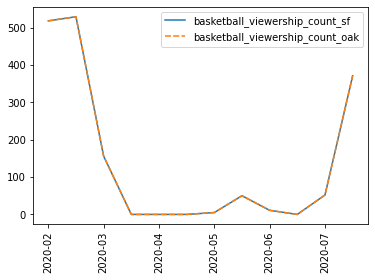

In [45]:
with warnings.catch_warnings():
    
    warnings.simplefilter('ignore')
    fig, ax = plt.subplots()
    both_monthly['month'] = pd.to_datetime(both_monthly['month'])
    sns.lineplot(data=both_monthly[['month', 'basketball_viewership_count_sf', 
                                    'basketball_viewership_count_oak']], ax=ax)

    ax.set_xticklabels(both_monthly['month'].dt.strftime('%Y-%m'))
    ticks = [item.get_text() for item in ax.get_xticklabels()]

    plt.xticks(rotation=90);

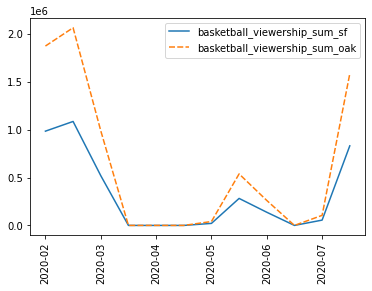

In [46]:
with warnings.catch_warnings():
    
    warnings.simplefilter('ignore')
    fig, ax = plt.subplots()
    both_monthly['month'] = pd.to_datetime(both_monthly['month'])
    sns.lineplot(data=both_monthly[['month', 'basketball_viewership_sum_sf', 
                                    'basketball_viewership_sum_oak']], ax=ax)

    ax.set_xticklabels(both_monthly['month'].dt.strftime('%Y-%m'))
    ticks = [item.get_text() for item in ax.get_xticklabels()]

    plt.xticks(rotation=90);

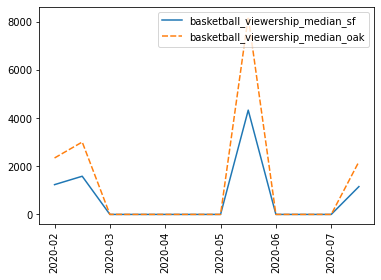

In [47]:
with warnings.catch_warnings():
    
    warnings.simplefilter('ignore')
    fig, ax = plt.subplots()
    both_monthly['month'] = pd.to_datetime(both_monthly['month'])
    sns.lineplot(data=both_monthly[['month', 'basketball_viewership_median_sf', 
                                    'basketball_viewership_median_oak']], ax=ax)

    ax.set_xticklabels(both_monthly['month'].dt.strftime('%Y-%m'))
    ticks = [item.get_text() for item in ax.get_xticklabels()]

    plt.xticks(rotation=90);